<a href="https://colab.research.google.com/github/qamtam/Hands-on-machine-learning/blob/main/CH12_with_notes_and_homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
print(os.path.curdir)

.


In [ ]:
import sys
assert sys.version_info >= (3,5)

import sklearn
assert sklearn.__version__ >= "0.20"

try:
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
from tensorflow import keras

import numpy as np
assert tf.__version__ >= "2.0"
import os

np.random.seed(42)
tf.random.set_seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [ ]:
tf.constant([[ 1., 2., 3.],
             [4., 5., 6.]])# <-- macierz

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [ ]:
#scalar
tf.constant(42)

<tf.Tensor: shape=(), dtype=int32, numpy=42>

In [ ]:
t = tf.constant([[1., 2., 3.], [4., 5., 6.]])
t

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [ ]:
t* 2

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[ 2.,  4.,  6.],
       [ 8., 10., 12.]], dtype=float32)>

In [ ]:
t+10

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[11., 12., 13.],
       [14., 15., 16.]], dtype=float32)>

In [ ]:
t[..., 1]

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([2., 5.], dtype=float32)>

In [ ]:
t[:, 1]

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([2., 5.], dtype=float32)>

In [ ]:
t[..., 1, tf.newaxis]

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[2.],
       [5.]], dtype=float32)>

In [ ]:
#variables
v = tf.Variable([[1., 2., 3.], [4.,5.,6.]])
v.assign(2*v)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2.,  4.,  6.],
       [ 8., 10., 12.]], dtype=float32)>

In [ ]:
v[0,1].assign(420)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[  2., 420.,   6.],
       [  8.,  10.,  12.]], dtype=float32)>

In [ ]:
v.scatter_nd_update(indices=[[0,0], [1,2]], updates=[100., 200.])

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[100., 420.,   6.],
       [  8.,  10., 200.]], dtype=float32)>

In [ ]:
#our model for the chapter for now is california housing

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42
)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

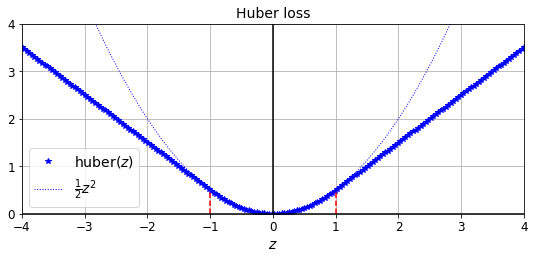

In [ ]:
#custom loss function

def huber_fn(y_true, y_pred):
  error = y_true - y_pred
  is_small_error = tf.abs(error) <1
  squared_loss = tf.square(error) /2
  linear_loss = tf.abs(error) - 0.5
  return tf.where(is_small_error, squared_loss, linear_loss)

#pretty pony picture
plt.figure(figsize=(9, 3.5)) #rozmiar obrazka
z = np.linspace(-4,4,200) #w jakich punktach na osi x liczymy y
plt.plot(z, huber_fn(0,z), "b*", linewidth=1, label="huber($z$)")
plt.plot(z, z**2 /2 , "b:", linewidth =1, label=r"$\frac{1}{2}z^2$")
plt.plot([-1, -1], [0, huber_fn(0., -1.)], "r--") #połącz linią prostą z x =-1 do x =-1 startując w y=0 i kończąc w y=hubner_fn(0,-1
plt.plot([1, 1], [0, huber_fn(0., 1.)], "r--")
plt.gca().axhline(y=0, color='k') #linia horyzontalna w zerze
plt.gca().axvline(x=0, color='k')
plt.axis([-4, 4, 0, 4])
plt.grid(True) #narysuj siatkę
plt.xlabel("$z$") #z w kursywie
plt.legend(fontsize=14)
plt.title("Huber loss", fontsize=14)
plt.show()



In [ ]:
X_train.shape[1:]
#używamy 1:, bo wymiar 0 to tylko liczba obserwacji
#efektywnie tylko[1] ze względu na to, że mamy (liczba obserwacji, liczba wymiarów)

(8,)

In [ ]:
input_shape = X_train.shape[1:] # per observation
model = keras.models.Sequential([
                                 keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal", input_shape=input_shape),
                                 keras.layers.Dense(1),
                                 ])
model.compile(loss=huber_fn, optimizer="nadam", metrics=["mae"])

model.fit(X_train_scaled, y_train, epochs=5,
validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
363/363 [==============================] - 0s 1ms/step - loss: 0.6235 - mae: 0.9953 - val_loss: 0.2862 - val_mae: 0.5866
Epoch 2/5
363/363 [==============================] - 0s 1ms/step - loss: 0.2197 - mae: 0.5177 - val_loss: 0.2382 - val_mae: 0.5281
Epoch 3/5
363/363 [==============================] - 0s 1ms/step - loss: 0.2051 - mae: 0.4975 - val_loss: 0.2196 - val_mae: 0.5040
Epoch 4/5
363/363 [==============================] - 0s 1ms/step - loss: 0.2002 - mae: 0.4908 - val_loss: 0.2069 - val_mae: 0.4917
Epoch 5/5
363/363 [==============================] - 0s 1ms/step - loss: 0.1964 - mae: 0.4843 - val_loss: 0.1940 - val_mae: 0.4751


In [ ]:
#save and load models with custom objects

model.save("my_model_with_a_custom_loss.h5")

model = keras.models.load_model("my_model_with_a_custom_loss.h5", 
                                custom_objects={"huber_fn": huber_fn})
#model jest już po kompilacji -> można fitować
model.fit(X_train_scaled, y_train, epochs=2, 
          validation_data=(X_valid_scaled, y_valid)
)
#chcemy threshold inny niż 0? trzeba zrobić funkcję robiącą funkcję

def create_huber(threshold=1.0):
  def huber_fn(y_true, y_pred):
    error = y_true - y_pred
    is_small_error = tf.abs(error) <threshold
    squared_loss = tf.square(error) / 2
    linear_loss = threshold * tf.abs(error) - threshold **2 /2
    #ze wzoru
    return tf.where(is_small_error, squared_loss, linear_loss) # ? Y N
  return huber_fn

model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=["mae"])
model.fit(X_train_scaled, y_train, epochs=2, validation_data=(X_valid_scaled, y_valid))


#można zasejwować, ale trzeba będzie przy ładowaniu wstawić konkretny parametr
model.save("my_model_with_a_custom_loss_threshold_2.h5")
model = keras.models.load_model("my_model_with_a_custom_loss_threshold_2.h5",
  custom_objects={"huber_fn": create_huber(2.0)})

model.fit(X_train_scaled,y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

#jeśli chcemy iminąć ten problem trzeba subklasować keras.losses.loss i zaimplementować get_config

class HuberLoss(keras.losses.Loss):
  def __init__(self, threshold=1.0, **kwargs):
    self.threshold = threshold
    super().__init__(**kwargs)
  def call(self, y_true, y_pred):
    error = y_true - y_pred
    is_small_error = tf.abs(error) <self.threshold
    squared_loss = tf.square(error) / 2
    linear_loss = self.threshold * tf.abs(error) - self.threshold**2 /2
    return tf.where(is_small_error, squared_loss, linear_loss)
  def get_config(self):
    base_config = super().get_config()
    return {**base_config, "threshold" : self.threshold}
    #zwracamy wszystko z klasy Loss dokładając nasz włąsny keyword pair threshold z defklasy

model = keras.models.Sequential([
                                 keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal", 
                                 input_shape=input_shape),
                                 keras.layers.Dense(1),
])

model.compile(loss=HuberLoss(2.), optimizer="nadam", metrics=["mae"])
model.fit(X_train_scaled, y_train, epochs=2, validation_data=(X_valid_scaled, y_valid))



























































Epoch 1/2
363/363 [==============================] - 0s 1ms/step - loss: 0.1934 - mean_absolute_error: 0.4797 - val_loss: 0.1905 - val_mean_absolute_error: 0.4695
Epoch 2/2
363/363 [==============================] - 0s 1ms/step - loss: 0.1909 - mean_absolute_error: 0.4754 - val_loss: 0.1844 - val_mean_absolute_error: 0.4665
Epoch 1/2
363/363 [==============================] - 0s 1ms/step - loss: 0.2127 - mae: 0.4763 - val_loss: 0.2105 - val_mae: 0.4620
Epoch 2/2
363/363 [==============================] - 0s 1ms/step - loss: 0.2100 - mae: 0.4733 - val_loss: 0.2006 - val_mae: 0.4628
Epoch 1/2
363/363 [==============================] - 1s 1ms/step - loss: 0.2076 - mean_absolute_error: 0.4705 - val_loss: 0.1965 - val_mean_absolute_error: 0.4514
Epoch 2/2
363/363 [==============================] - 0s 1ms/step - loss: 0.2052 - mean_absolute_error: 0.4664 - val_loss: 0.2194 - val_mean_absolute_error: 0.4688
Epoch 1/2
363/363 [==============================] - 0s 1ms/step - loss: 0.7095 - mae:

In [ ]:
#ponieważ skompilowało się poprzez subklasę a nie porpzez funkcję można zasejwować BEZ obawy o stratę parametru
model.save("my_model_with_a_custom_loss_class.h5")
model = keras.models.load_model("my_model_with_a_custom_loss_class.h5", 
                                custom_objects={"HuberLoss": HuberLoss})
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.loss.threshold

Epoch 1/2
363/363 [==============================] - 1s 1ms/step - loss: 0.2286 - mean_absolute_error: 0.4970 - val_loss: 0.2120 - val_mean_absolute_error: 0.4723
Epoch 2/2
363/363 [==============================] - 0s 1ms/step - loss: 0.2216 - mean_absolute_error: 0.4904 - val_loss: 0.2045 - val_mean_absolute_error: 0.4725


2.0

In [ ]:
#other custom function

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

def my_softplus(z):
  return tf.math.log(tf.exp(z) + 1.0)

def my_glorot_initializer(shape, dtype=tf.float32):
  stddev = tf.sqrt(2. / (shape[0] + shape[1]))
  return tf.random.normal(shape, stddev=stddev, dtype=dtype)

def my_l1_regularizer(weights):
  return tf.reduce_sum(tf.abs(0.01 * weights))

def my_positive_weights(weights):
  return tf.where(weights < 0., tf.zeros_like(weights), weights)

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1, activation=my_softplus,
                       kernel_regularizer=my_l1_regularizer,
                       kernel_constraint=my_positive_weights,
                       kernel_initializer=my_glorot_initializer),
])

model.compile(loss="mse", optimizer="nadam", metrics=["mae"])
model.fit(X_train_scaled, y_train, epochs=2, validation_data=(X_valid_scaled, y_valid))


















model = keras.models.load_model(
    "my_model_with_many_custom_parts.h5",
    custom_objects={
       "my_l1_regularizer": my_l1_regularizer,
       "my_positive_weights": my_positive_weights,
       "my_glorot_initializer": my_glorot_initializer,
       "my_softplus": my_softplus,
    })






Epoch 1/2
363/363 [==============================] - 1s 1ms/step - loss: 1.5542 - mae: 0.8962 - val_loss: 1.4154 - val_mae: 0.5607
Epoch 2/2
363/363 [==============================] - 0s 1ms/step - loss: 0.5943 - mae: 0.5256 - val_loss: 1.4399 - val_mae: 0.5137


In [ ]:
model.save("my_model_with_many_custom_parts.h5")
model = keras.models.load_model(
    "my_model_with_many_custom_parts.h5",
    custom_objects={
      "my_l1_regularizer": my_l1_regularizer,
      "my_positive_weights": my_positive_weights,
      "my_glorot_initializer": my_glorot_initializer,
      "my_softplus": my_softplus,
    })



In [ ]:
#jeśli chcemy żeby się zmienione parametry zapisały, ponownie należy stworzyć subklasę
class MyL1Regularizer(keras.regularizers.Regularizer):
  def __init__(self, factor):
    self.factor = factor
  def __call__(self, weights):
    return tf.reduce_sum(tf.abs(self.factor * weights))
  def get_config(self):
    return {"factor": self.factor}

model = keras.models.Sequential([
                         keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                         input_shape=input_shape),
                         keras.layers.Dense(1, activation=my_softplus,
                                             kernel_regularizer=MyL1Regularizer(0.01),
                                             kernel_constraint=my_positive_weights,
                                             kernel_initializer=my_glorot_initializer),
])
model.compile(loss="mse", optimizer="nadam", metrics=["mae"])

In [ ]:
model.fit(X_train_scaled, y_train, epochs=2, validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 1ms/step - loss: 1.5147 - mae: 0.8886 - val_loss: 1.5957 - val_mae: 0.5688
Epoch 2/2
363/363 [==============================] - 0s 1ms/step - loss: 0.6072 - mae: 0.5331 - val_loss: 2.7460 - val_mae: 0.5369


In [ ]:
model.save("my_model_with_many_custom_parts.h5")


model = keras.models.load_model(
    "my_model_with_many_custom_parts.h5",
    custom_objects={
       "MyL1Regularizer": MyL1Regularizer, # ta instancja klasy ma już w sobie czynnik == 0.01
       "my_positive_weights": my_positive_weights, # warto wziąć pod uwagę, że funkcje zaczynają się od małej litery a klasy od wielkiej
       "my_glorot_initializer": my_glorot_initializer,
       "my_softplus": my_softplus,
    })


  

In [ ]:
#metrryki, KURWA

In [ ]:
#można użyć hubera jako metrykę (chociaż to dosyc słaba opcja)
model.compile(loss="mse", optimizer="nadam", metrics=[create_huber(2.0)])

In [ ]:
#streaming metrics over all examples not just over all batches
precision = keras.metrics.Precision()
precision([0, 1, 1, 1, 0, 1, 0, 1], [1, 1, 0, 1, 0, 1, 0, 1])

<tf.Tensor: shape=(), dtype=float32, numpy=0.8>

In [ ]:
precision([0, 1, 0, 0, 1, 0, 1, 1], [1, 0, 1, 1, 0, 0, 0, 0])

<tf.Tensor: shape=(), dtype=float32, numpy=0.5>

In [ ]:
#najpierw policzyliśmy precyzję (true positivy na jedynkach/wszystkie strzały z jedynek)
#potem "przeciągnęliśmy" tę precyzje na drugi batch (w 106), nie było tam żadnych true positivów
#ale łącznie mieliśmy cztery true positivy na 8 przewidzianych jedynek (4+0)/(5+3) więc mamy 50%

In [ ]:
class HuberMetric(keras.metrics.Metric):
    def __init__(self, threshold=1.0, **kwargs):
        super().__init__(**kwargs) # handles base args (e.g., dtype)
        self.threshold = threshold
        self.huber_fn = create_huber(threshold) # TODO: investigate why this fails
        self.total = self.add_weight("total", initializer="zeros")
        self.count = self.add_weight("count", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        metric = self.huber_fn(y_true, y_pred)
        self.total.assign_add(tf.reduce_sum(metric))
        self.count.assign_add(tf.cast(tf.size(y_true), tf.float32))
    def result(self):
        return self.total / self.count
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

In [ ]:
m = HuberMetric(2.)

# total = 2 * |10 - 2| - /2²/2 = 14
# count = 1
# result = 14 / 1 = 14
m(tf.constant([[2.]]), tf.constant([[10.]])) 

<tf.Tensor: shape=(), dtype=float32, numpy=14.0>

In [ ]:
# total = total + (|1 - 0|² / 2) + (2 * |9.25 - 5| - 2² / 2) = 14 + 7 = 21
# count = count + 2 = 3
# result = total / count = 21 / 3 = 7
m(tf.constant([[0.], [5.]]), tf.constant([[1.], [9.25]]))

m.result()

<tf.Tensor: shape=(), dtype=float32, numpy=7.0>

In [ ]:
#custome layers

#lambda layers
exp_layer = keras.layers.Lambda(lambda x: tf.exp(x)) #zwróci ten x zaraz przy lambdzie czyli exp x

#layers as a class instnace
class MyDense(keras.layers.Layer):
  def __init__(self, units, activation=None, **kwargs):
    super().__init__(**kwargs)
    self.units = units
    self.activation = keras.activations.get(activation)
  #batch_input_shape = [batch_size, input_dim(czyli featuresy)]
  #powiedzmy 4 zdjęcia po 256 pixeli w batchu, następna warstwa ma 3 neurony

  def build(self, batch_input_shape):
    self.kernel = self.add_weight(
        name="kernel", shape=[batch_input_shape[-1], self.units], initializer="glorot_normal"
    ) # dla każdego zdjęcia ten sam kernel w batchu, oczywiście 256 *3
    self.bias = self.add_weight(
        name="bias", shape=[self.units], initializer="zeros"
    )
    super().build(batch_input_shape)
  def call(self, X):
    return self.activation(X @ self.kernel + self.bias)
  def compute_output_shape(self, batch_input_shape):
    return tf.TensorShape(batch_input_shape.as_list()[:-1] + [self.units])
    #każde zdjęcie ma "swoją" kolejną warstwę w sieci neuronowej, dlatego wymiarem 
    #jest [4 * 3] : 4 zdjęcia w drugiej warstwie mają 3 neurony, lcizymy wszystkie
    #naraz bo kernel jest ten sam
  def get_config(self):
    base_config = super().get_config()
    return {**base_config, "units": self.units,
            "activation": keras.activations.serialize(self.activation)}








In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([
                                 MyDense(30, activation="relu", input_shape=input_shape),
                                 MyDense(1)
])

model.compile(loss="mse", optimizer="nadam")
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/2
363/363 [==============================] - 1s 1ms/step - loss: 2.2563 - val_loss: 0.9472
Epoch 2/2
162/162 [==============================] - 0s 667us/step - loss: 0.5474


0.5473727583885193

In [ ]:
model.save("my_model_with_a_custom_layer.h5")
model = keras.models.load_model("my_model_with_a_custom_layer.h5",
custom_objects={"MyDense": MyDense})

In [ ]:
#różne zachowanie w treningu i podczas predykcji
class MyGaussianNoise(keras.layers.Layer):
  def __init__(self, stddev, **kwargs):
    super().__init__(**kwargs)
    self.stddev = stddev

  def call(self, X, training=None):
    if training:
      noise = tf.random.normal(tf.shape(X), stddev = self.stddev)
      return X + noise
    else:
      return X
  
  def compute_output_shape(self, batch_input_shape):
    return batch_input_shape

In [ ]:
model.compile(loss="mse", optimizer = "nadam")
model.fit(X_train_scaled, y_train, epochs=2, validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/2
363/363 [==============================] - 0s 1ms/step - loss: 0.4904 - val_loss: 0.5329
Epoch 2/2
162/162 [==============================] - 0s 661us/step - loss: 0.3990


0.39900389313697815

In [ ]:
#customowe modele
#subklasuj keras.Model
#stwórz warstwy i zmienne w konstruktorze
#zrób metodę call by model robił to co do niego nalkeży

X_new_scaled = X_test_scaled
class ResidualBlock(keras.layers.Layer):
  def __init__(self, n_layers, n_neurons, **kwargs):
   super().__init__(**kwargs)
   self.hidden = [keras.layers.Dense(n_neurons, activation="elu",
                                     kernel_initializer="he_normal")
   for _ in range(n_layers)]
  def call(self, inputs):
    Z = inputs
    for layer in self.hidden:
      Z= layer(Z)
      return inputs + Z
    

In [ ]:
class ResidualRegressor(keras.models.Model):
  def __init__(self, output_dim, **kwargs):
    super().__init__(**kwargs)
    self.hidden1 = keras.layers.Dense(30, activation="elu",
    kernel_initializer="he_normal")
    self.blocka1 = ResidualBlock(2,30)
    self.blocka2 = ResidualBlock(2,30)
    self.out = keras.layers.Dense(output_dim)
  def call(self, inputs):
    Z = self.hidden1(inputs)
    for _ in range(1+3):
      Z = self.blocka1(Z)
    Z = self.blocka2(Z)
    return self.out(Z)


In [ ]:
model = ResidualRegressor(1)
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs = 5)
score = model.evaluate(X_test_scaled, y_test)
y_pred = model.predict(X_new_scaled)

Epoch 1/5
363/363 [==============================] - 0s 1ms/step - loss: 7.3498
Epoch 2/5
363/363 [==============================] - 0s 1ms/step - loss: 2.4611
Epoch 3/5
363/363 [==============================] - 0s 1ms/step - loss: 2.0412
Epoch 4/5
363/363 [==============================] - 0s 1ms/step - loss: 1.2341
Epoch 5/5
162/162 [==============================] - 0s 795us/step - loss: 2.7231


In [ ]:
model.save("my_custom_model.ckpt")
model = keras.models.load_model("my_custom_model.ckpt")
history = model.fit(X_train_scaled, y_train, epochs=5)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: my_custom_model.ckpt/assets
Epoch 1/5
363/363 [==============================] - 0s 1ms/step - loss: 0.8515
Epoch 2/5
363/363 [==============================] - 0s 1ms/step - loss: 0.5273
Epoch 3/5
363/363 [==============================] - 0s 1ms/step - loss: 0.8250
Epoch 4/5
363/363 [==============================] - 0s 1ms/step - loss: 0.9742
Epoch 5/5
363/363 [==============================] - 0s 1ms/step - loss: 0.4624


In [ ]:
#^ subclassing API
#v sequential API

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

block1 = ResidualBlock(2, 30)
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="elu", kernel_initializer="he_normal"),
    block1, block1, block1, block1,
    ResidualBlock(2, 30),
    keras.layers.Dense(1)
])
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=5)
score = model.evaluate(X_test_scaled, y_test)
y_pred = model.predict(X_new_scaled)

Epoch 1/5
363/363 [==============================] - 0s 959us/step - loss: 1.3756
Epoch 2/5
363/363 [==============================] - 0s 997us/step - loss: 0.5827
Epoch 3/5
363/363 [==============================] - 0s 1ms/step - loss: 0.4849
Epoch 4/5
363/363 [==============================] - 0s 934us/step - loss: 0.4010
Epoch 5/5
162/162 [==============================] - 0s 715us/step - loss: 0.4782


In [ ]:
#metryki i lossy na podstawie nie tylko różnicy y_pred i y_test
#ale również internali
class ReconstructingRegressor(keras.models.Model):
  def __init__(self, output_dim, **kwargs):
    super().__init__(**kwargs)
    self.hidden = [keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal") 
                  for _ in range(5)]
    self.out = keras.layers.Dense(output_dim)
    #standardowe mlp 5 gęstych i warstwa wyściowa u nas 1 ze wzgleędu na regresję
  def build(self, batch_input_shape):
    #batch_input_shape = [batch zie, n_inputs]
    #n_inputs to cechy jednostki
     n_inputs = batch_input_shape[-1]
     self.reconstruct = keras.layers.Dense(n_inputs)
     super().build(batch_input_shape)
  def call(self, inputs, training=None):
    Z= inputs
    for layer in self.hidden:
      Z = layer(Z)
    reconstruction = self.reconstruct(Z) # próbujemy zrekonstruować inputy
    recon_loss = tf.reduce_mean(tf.square(reconstruction- inputs))
    self.add_loss(0.05* recon_loss) #błąd dokładamy do straty
    return self.out(Z)


keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = ReconstructingRegressor(1)
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=20)
y_pred = model.predict(X_test_scaled)



Epoch 1/2


InaccessibleTensorError: ignored

In [ ]:
class ReconstructingRegressor(keras.models.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [keras.layers.Dense(30, activation="selu",
                                          kernel_initializer="lecun_normal")
                       for _ in range(5)]
        self.out = keras.layers.Dense(output_dim)
        # TODO: check https://github.com/tensorflow/tensorflow/issues/26260
        #self.reconstruction_mean = keras.metrics.Mean(name="reconstruction_error")

    def build(self, batch_input_shape):
        n_inputs = batch_input_shape[-1]
        self.reconstruct = keras.layers.Dense(n_inputs)
        super().build(batch_input_shape)

    def call(self, inputs, training=None):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        reconstruction = self.reconstruct(Z)
        recon_loss = tf.reduce_mean(tf.square(reconstruction - inputs))
        self.add_loss(0.05 * recon_loss)
        #if training:
        #    result = self.reconstruction_mean(recon_loss)
        #    self.add_metric(result)
        return self.out(Z)

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = ReconstructingRegressor(1)
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=2)
y_pred = model.predict(X_test_scaled)

Epoch 1/2


InaccessibleTensorError: ignored

In [ ]:
y_train

array([[1.442],
       [1.687],
       [1.621],
       ...,
       [0.68 ],
       [0.613],
       [1.97 ]])

In [ ]:
#pochodne z autodiffem

# df/dx to "o ile razy więcej zmieni się wartość funkcji (od pewnej minimalnej wartości epsilon
# jeśli jej zmienną powiększę o ten epsilon"

# czyli nie może być f(x + e) - f(x) bo to tylko różnica w wartościach
# musi być (f(x+e) - f(x)) /e, bo wtedy bierze się pod uwagę to powiększenie i w efekcie
# dynamikę zmiany


In [ ]:
def f(w1, w2):
    return 3 * w1 ** 2 + 2 * w1 * w2

w1, w2 = 5, 3
e = 1e-6
(f(w1 + e, w2) - f(w1, w2)) / e

36.000003007075065

In [ ]:
f(w1, w2) # nie ma wpływu na pochodną


105

In [ ]:
f(w1+e, w2)

105.000036000003

In [ ]:
f(w1, w2+e)

105.00001

In [ ]:
f(w1+0.936*e, w2+0.267*e)

105.00003636600314

In [ ]:
w1, w2 = tf.Variable(5.), tf.Variable(3.)
with tf.GradientTape() as tape:
    z = f(w1, w2)

gradients = tape.gradient(z, [w1, w2])

In [ ]:
z

<tf.Tensor: shape=(), dtype=float32, numpy=105.0>

In [ ]:
with tf.GradientTape() as tape:
    z = f(w1, w2)

dz_dw1 = tape.gradient(z, w1)
try:
    dz_dw2 = tape.gradient(z, w2)
except RuntimeError as ex:
    print(ex)
    

GradientTape.gradient can only be called once on non-persistent tapes.


In [ ]:
with tf.GradientTape(persistent=True) as tape:
    z = f(w1, w2)

dz_dw1 = tape.gradient(z, w1)
dz_dw2 = tape.gradient(z, w2) # works now!
del tape

In [ ]:
dz_dw1, dz_dw2

(<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>)

In [ ]:
c1, c2 = tf.constant(5.), tf.constant(3.)# constants aren't tracked by default
with tf.GradientTape() as tape:
    z = f(c1, c2)

gradients = tape.gradient(z, [c1, c2])

In [ ]:
gradients

[None, None]

In [ ]:
with tf.GradientTape() as tape:
    tape.watch(c1)
    tape.watch(c2)
    z = f(c1, c2)

gradients = tape.gradient(z, [c1, c2])
gradients

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

In [ ]:
with tf.GradientTape() as tape:
    z1 = f(w1, w2 + 2.)
    z2 = f(w1, w2 + 5.)
    z3 = f(w1, w2 + 7.)

tape.gradient([z1, z2, z3], [w1, w2])# dlaczego? zielone podkreślenie na stronie 401

[<tf.Tensor: shape=(), dtype=float32, numpy=136.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=30.0>]

In [ ]:
with tf.GradientTape(persistent=True) as tape:
    z1 = f(w1, w2 + 2.)
    z2 = f(w1, w2 + 5.)
    z3 = f(w1, w2 + 7.)

[tape.gradient(z, [w1, w2]) for z in (z1, z2, z3)]


[[<tf.Tensor: shape=(), dtype=float32, numpy=40.0>,
  <tf.Tensor: shape=(), dtype=float32, numpy=10.0>],
 [<tf.Tensor: shape=(), dtype=float32, numpy=46.0>,
  <tf.Tensor: shape=(), dtype=float32, numpy=10.0>],
 [<tf.Tensor: shape=(), dtype=float32, numpy=50.0>,
  <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]]

In [ ]:

tf.stack([tape.gradient(z, [w1, w2]) for z in (z1, z2, z3)])

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[40., 10.],
       [46., 10.],
       [50., 10.]], dtype=float32)>

In [ ]:
tf.reduce_sum(tf.stack([tape.gradient(z, [w1, w2]) for z in (z1, z2, z3)]), axis=0)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([136.,  30.], dtype=float32)>

In [ ]:
def f(w1, w2):
    return 3 * w1 ** 2 + tf.stop_gradient(2 * w1 * w2)
w1, w2 = tf.Variable(5.), tf.Variable(3.)

with tf.GradientTape() as tape:
    z = f(w1, w2)

tape.gradient(z, [w1, w2])

[<tf.Tensor: shape=(), dtype=float32, numpy=30.0>, None]

In [ ]:
def print_status_bar(iteration, total, loss, metrics=None):
    metrics = " - ".join(["{}: {:.4f}".format(m.name, m.result())
                         for m in [loss] + (metrics or [])])
    end = "" if iteration < total else "\n"
    print("\r{}/{} - ".format(iteration, total) + metrics,
          end=end)

In [ ]:
def random_batch(X, y, batch_size=32):
    idx = np.random.randint(len(X), size=batch_size)
    return X[idx], y[idx]

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

l2_reg = keras.regularizers.l2(0.05)
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="elu", kernel_initializer="he_normal",
                       kernel_regularizer=l2_reg),
    keras.layers.Dense(1, kernel_regularizer=l2_reg)
])

import time

mean_loss = keras.metrics.Mean(name="loss")
mean_square = keras.metrics.Mean(name="mean_square")
for i in range(1, 50 + 1):
    loss = 1 / i
    mean_loss(loss)
    mean_square(i ** 2)
    print_status_bar(i, 50, mean_loss, [mean_square])
    time.sleep(0.05)

50/50 - loss: 0.0900 - mean_square: 858.5000


In [ ]:
#version with progress bar


def progress_bar(iteration, total, size=30):
    running = iteration < total # konczymy?
    c = ">" if running else "=" #[===>] lub [====]
    p = (size - 1) * iteration // total # liczba części która powinna być
    #previous po prostu; size - 1 bo nawet ostatni chcemy zeby byl piosany przez c
    fmt = "{{:-{}d}}/{{}} [{{}}]".format(len(str(total))) # podwójne nawiasy bo to formatka do formatki
    params = [iteration, total, "=" * p + c + "." * (size - p - 1)]
    return fmt.format(*params)

progress_bar(+120, 10000, size=30)

'  120/10000 [>.............................]'

In [ ]:
fmt = "{{:-{}d}}/{{}} [{{}}]".format(len(str(20
                                            )))

In [ ]:
fmt

'{:-2d}/{} [{}]'

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

n_epochs = 5
batch_size = 32
n_steps = len(X_train) // batch_size
optimizer = keras.optimizers.Nadam(lr= 0.01)
loss_fn = keras.losses.mean_squared_error
mean_loss = keras.metrics.Mean()
metrics = [keras.metrics.MeanAbsoluteError()]

for epoch in range(1, n_epochs + 1):
    print("Epoch {}/{}".format(epoch, n_epochs))
    for step in range(1, n_steps + 1):
        X_batch, y_batch = random_batch(X_train_scaled, y_train)
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            total_batch_loss = tf.add_n([main_loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        #apply w każdej parze ^
        # v jeśli mamy jakąś modyfikację kernela, to tutaj będzie właśnie aplikowana
        # przykład - skalowanie max norm - jeśli  norma l2 danej warstwy przekracza
        # m to wszystkie wagi tej warstwy (czyli zmienne) będą przeskalowane przez taki czynnik, żeby ich l2 <= m
        for variable in model.variables:
            if variable.constraint is not None:
                variable.assign(variable.constraint(variable))
        mean_loss(total_batch_loss) # update the "MAIN" mean loss by the loss of this epoch
        for metric in metrics:
            metric(y_batch, y_pred)
        print_status_bar(step * batch_size, len(y_train), mean_loss, metrics)
    print_status_bar(len(y_train), len(y_train), mean_loss, metrics)
    for metric in [mean_loss] + metrics: # resets but for each epoch
        metric.reset_states()

Epoch 1/5

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

11610/11610 - mean: 1.3955 - mean_absolute_error: 0.5722
Epoch 2/5
11610/11610 - mean: 0.6774 - mean_absolute_error: 0.5280
Epoch 3/5
11610/11610 - mean: 0.6351 - mean_absolute_error: 0.5177
Epoch 4/5
11610/11610 - mean: 0.6384 - mean_absolute_error: 0.5181
Epoch 5/5
11610/11610 - mean: 0.6440 - mean_absolute_error: 0.5222


In [ ]:
#funkcje i grafy w tensorflow
def cube(x):
  return x ** 3

cube(2)
cube(tf.Variable(3.0))
#works with both python value and a tensor

<tf.Tensor: shape=(), dtype=float32, numpy=27.0>

In [ ]:
#use tf.function() to convert a python function to a tensorflwo function
tf_cube = tf.function(cube)
tf_cube

In [ ]:
# TF Function can then be used exactly as athe original function, but will always return tensors
tf_cube(2)


<tf.Tensor: shape=(), dtype=int32, numpy=8>

In [ ]:
#without conversion we can just use a decorator
@tf.function
def tf_cube(x):
  return x ** 2

In [ ]:
#why use a tensorflow function?
#works with tensors, duh
#generates optimized computation graph
#works faster than a python function

#notka - Keras to robi automatycznie
#jeśli chcemy by tego nie robił ustawiamy przy model.compile(run_eagerly=True) -> nie generuje się wtedy grafu ani tf.function


#autograph and Tracing


In [ ]:
# autograph -> 
# 1) ogarnięcie słów kluczowych jak while and if
# 2) autograph używa tych słów by przerobić na lepszą wersję kodu
#      npo. while --> tf.while_loop()
# tracing ->
# po zbudowanie tej ulepszonej funkcji jest użyta za pomocą symbolicznego (pustego) tensora
# 3) dopiero tutaj się tworzy graf, funkcja jest"aktywowana w modzie grafowym"
# mamy graph mode służący stworzeniu odpowiedniego "rozmiaru" grafu
# #mamy eager mode, który jest normalną egzekucją
# eager mode po prostu "leci z kodem" po staremu linijka po linijce bez zatrzymywania

In [ ]:
#zadanie 12
#zbuduj własną warstwę która zwobi layer normalization
class LayerNormalization(keras.layers.Layer):
    def __init__(self, eps=0.001, **kwargs):
        super().__init__(**kwargs)
        self.eps = eps

    def build(self, batch_input_shape):
        self.alpha = self.add_weight(
            name="alpha", shape=batch_input_shape[-1:],
            initializer="ones")
        self.beta = self.add_weight(
            name="beta", shape=batch_input_shape[-1:],
            initializer="zeros")
        super().build(batch_input_shape) # must be at the end

    def call(self, X):
        mean, variance = tf.nn.moments(X, axes=-1, keepdims=True)
        return self.alpha * (X - mean) / (tf.sqrt(variance + self.eps)) + self.beta

    def compute_output_shape(self, batch_input_shape):
        return batch_input_shape

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "eps": self.eps}

In [ ]:
X = X_train.astype(np.float32)

custom_layer_norm = LayerNormalization()
keras_layer_norm = keras.layers.LayerNormalization()

tf.reduce_mean(keras.losses.mean_absolute_error(
    keras_layer_norm(X), custom_layer_norm(X)))

<tf.Tensor: shape=(), dtype=float32, numpy=5.496049e-08>

In [ ]:
random_alpha = np.random.rand(X.shape[-1])
random_beta = np.random.rand(X.shape[-1])

custom_layer_norm.set_weights([random_alpha, random_beta])
keras_layer_norm.set_weights([random_alpha, random_beta])

tf.reduce_mean(keras.losses.mean_absolute_error(
    keras_layer_norm(X), custom_layer_norm(X)))

<tf.Tensor: shape=(), dtype=float32, numpy=4.619356e-08>

In [ ]:
X.shape[-1] # nieakceptowalne jako tensorshape

8

In [ ]:
X.shape[-1:] # akceptowalne jako tensorshape

(8,)

In [ ]:
#zadanie trzynste
#FASHION MNIST

fashion = keras.datasets.fashion_mnist

(X_train, y_train),(X_test, y_test) = fashion.load_data()

In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

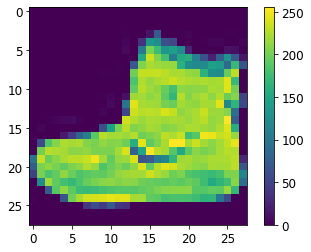

In [ ]:
plt.figure()
plt.imshow(X_train[0])
plt.colorbar()
plt.grid(False)
plt.show()

In [ ]:
X_train = X_train /255.0
X_test = X_test / 255.0

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train)

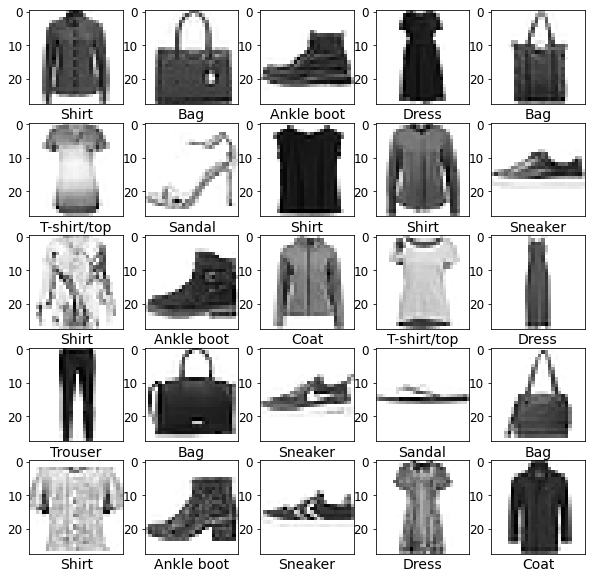

In [ ]:
#pretty pony pictures
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1) #5 kolumn, 5 rzędów, i-ty obrazek ma i+1 pozycję (ze względu na range)
    plt.xticks([]) #xticks([]) wyłącza oznaczenie osi x
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])
plt.show()

In [ ]:
base_model = keras.Sequential([
                               keras.layers.Flatten(input_shape=(28,28)),
                               keras.layers.Dense(128, activation='relu'),
                               keras.layers.Dense(10)
])
base_model.compile(optimizer='adam',
                   loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                   metrics=['accuracy'])
#if we used Dense 10, activation=softmax we don't have logits, we have actual probabilities and then we don't need from_logits=true
history = base_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, verbose=2)

Epoch 1/10
1407/1407 - 3s - loss: 0.5190 - accuracy: 0.8205 - val_loss: 0.4277 - val_accuracy: 0.8473
Epoch 2/10
1407/1407 - 2s - loss: 0.3902 - accuracy: 0.8600 - val_loss: 0.3901 - val_accuracy: 0.8610
Epoch 3/10
1407/1407 - 3s - loss: 0.3475 - accuracy: 0.8744 - val_loss: 0.3631 - val_accuracy: 0.8697
Epoch 4/10
1407/1407 - 3s - loss: 0.3209 - accuracy: 0.8828 - val_loss: 0.3457 - val_accuracy: 0.8724
Epoch 5/10
1407/1407 - 2s - loss: 0.3007 - accuracy: 0.8908 - val_loss: 0.3487 - val_accuracy: 0.8705
Epoch 6/10
1407/1407 - 2s - loss: 0.2865 - accuracy: 0.8947 - val_loss: 0.3285 - val_accuracy: 0.8796
Epoch 7/10
1407/1407 - 3s - loss: 0.2753 - accuracy: 0.8971 - val_loss: 0.3287 - val_accuracy: 0.8801
Epoch 8/10
1407/1407 - 2s - loss: 0.2626 - accuracy: 0.9029 - val_loss: 0.3472 - val_accuracy: 0.8747
Epoch 9/10
1407/1407 - 2s - loss: 0.2503 - accuracy: 0.9066 - val_loss: 0.3424 - val_accuracy: 0.8786
Epoch 10/10
1407/1407 - 2s - loss: 0.2420 - accuracy: 0.9101 - val_loss: 0.3323 - 

In [ ]:
base_model.evaluate(X_test, y_test, verbose=2)

313/313 - 0s - loss: 0.3638 - accuracy: 0.8692


[0.3638402223587036, 0.8691999912261963]

In [ ]:
#to do
# główny punkt: zrobić to samo własną pętlą
# # oprócz głównej pętli chcemy, by model pokazywał epoch, iterację , training loss, mean training loss
# # podczas każdego epochu (aktualizowane z każdą iteracją)
# # jak również validation loss i validation accuracy
# # na koniec każdego epochu

# drugi główny punkt : użyć innego optymalizatora dla górnych warst

n_epochs = 10
batch_size = 32
n_steps = len(X_train) // batch_size
optimizer = keras.optimizers.Nadam(lr = 0.01)
loss_fn = keras.losses.SparseCategoricalCrossentropy()
mean_loss = keras.metrics.Mean()
validation_loss_fn = keras.losses.SparseCategoricalCrossentropy(name= "validation loss") # nie ma rezultatu bo to funkcja straty
validation_mean_loss = keras.metrics.Mean(name= "validation mean loss")
metrics = [keras.metrics.SparseCategoricalAccuracy()]
validation_metrics = [keras.metrics.SparseCategoricalAccuracy(name="validation accuracy")]
l2_reg = keras.regularizers.l2(0.05)
"""
model = keras.models.Sequential([
                                keras.layers.Flatten(input_shape=(28,28)),
                                keras.layers.Dense(200, activation="selu", kernel_initializer="lecun_normal", kernel_regularizer=l2_reg),
                                keras.layers.Dense(200, activation="selu", kernel_initializer="lecun_normal", kernel_regularizer=l2_reg),
                                keras.layers.Dense(10, activation="softmax")
])
"""
model = keras.Sequential([
                               keras.layers.Flatten(input_shape=(28,28)),
                               keras.layers.Dense(128, activation='relu'),
                               keras.layers.Dense(10, activation="softmax")
])
#modelu nie musimy kompilować bo zajmiemy się pętlą treningową ręcznie

#funkcja pomocnicza
def random_batch(X, y, batch_size=32):
  idx = np.random.randint(len(X), size=batch_size)
  return X[idx], y[idx]

#funkcja pomocnicza 2, bez animowania
def print_status_bar(iteration, total, loss, metrics=None, validation_metrics=None, validation_loss=None):
  metrics = " - ".join(["{}: {:4f}".format(m.name, m.result()) for m in [loss] + (metrics or []) + (validation_metrics or [])])
  end = "" if iteration < total else "\n"
  print("\r{}/{} - ".format(iteration, total) + metrics, end=end )


for epoch in range(1, n_epochs + 1):
  print("Epoch {}/{}".format(epoch, n_epochs))
  for step in range(1, 30):
    X_batch, y_batch = random_batch(X_train, y_train)
    with tf.GradientTape() as tape:
      y_pred = model(X_batch,  training=True)
      main_batch_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
      total_batch_loss = tf.add_n([main_batch_loss] + model.losses)
    gradients = tape.gradient(total_batch_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    mean_loss(total_batch_loss)
    for metric in metrics:
      metric(y_batch, y_pred)
    print_status_bar(step * batch_size, len(y_train), mean_loss, metrics)
  # compute validation metrics
  y_val_pred = model(X_val)
  
  validation_loss = tf.reduce_mean(validation_loss_fn(y_val, y_val_pred))
  total_validation_loss = tf.add_n([main_batch_loss] + model.losses)
  # print("\ntotal val loss\n", total_validation_loss )
  validation_mean_loss(total_validation_loss)
  """
  print("\nvalidation_mean_loss ", validation_mean_loss.result())
  print("\main loss,\n", mean_loss)
  """
  for validation_metric in validation_metrics:
    validation_metric(y_val, y_val_pred)
  validation_metrics = validation_metrics + [validation_mean_loss]

  print_status_bar(len(y_train), len(y_train), mean_loss, metrics, validation_metrics, validation_mean_loss)
  for metric in [mean_loss] + metrics  + validation_metrics + [validation_mean_loss]:
    metric.reset_states()
  validation_metrics.pop()

Epoch 1/10
45000/45000 - mean: 1.518992 - sparse_categorical_accuracy: 0.528017 - validation accuracy: 0.641533 - validation mean loss: 1.037991
Epoch 2/10
45000/45000 - mean: 0.778124 - sparse_categorical_accuracy: 0.713362 - validation accuracy: 0.769933 - validation mean loss: 0.537018
Epoch 3/10
45000/45000 - mean: 0.696034 - sparse_categorical_accuracy: 0.732759 - validation accuracy: 0.757000 - validation mean loss: 0.664279
Epoch 4/10
45000/45000 - mean: 0.636200 - sparse_categorical_accuracy: 0.783405 - validation accuracy: 0.786667 - validation mean loss: 0.659100
Epoch 5/10
45000/45000 - mean: 0.581872 - sparse_categorical_accuracy: 0.798491 - validation accuracy: 0.807000 - validation mean loss: 0.764255
Epoch 6/10
45000/45000 - mean: 0.596101 - sparse_categorical_accuracy: 0.803879 - validation accuracy: 0.784667 - validation mean loss: 0.694397
Epoch 7/10
45000/45000 - mean: 0.671982 - sparse_categorical_accuracy: 0.758621 - validation accuracy: 0.806867 - validation mean 

In [ ]:
y_train[5]

0

In [ ]:
X_batch, y_batch = random_batch(X_train, y_train)
y_batch[:10]

array([9, 2, 3, 5, 5, 7, 4, 4, 2, 2], dtype=uint8)

In [ ]:
y_batch = tf.one_hot(y_batch, depth=10)

In [ ]:
# 13  podpunkt b

upper_layers = keras.Sequential([
                                 keras.layers.Dense(10, activation="softmax")
])
lower_layers = keras.Sequential([
                               keras.layers.Flatten(input_shape=(28,28)),
                               keras.layers.Dense(128, activation='relu'),
])
model = keras.Sequential([
lower_layers,
upper_layers
])

optimizer_lower = keras.optimizers.Adam(lr=0.05)
optimizer_upper = keras.optimizers.Nadam(lr=0.2)


for epoch in range(1, n_epochs + 1):
  print("Epoch {}/{}".format(epoch, n_epochs))
  for step in range(1, 30):
    X_batch, y_batch = random_batch(X_train, y_train)
    with tf.GradientTape(persistent=True) as tape:
      y_pred = model(X_batch,  training=True)
      main_batch_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
      total_batch_loss = tf.add_n([main_batch_loss] + model.losses)
    for layers, optimizer in ((lower_layers, optimizer_lower),
                              (upper_layers, optimizer_upper)):
      
      gradients = tape.gradient(total_batch_loss, model.trainable_variables)
      optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    del tape
    mean_loss(total_batch_loss)
    for metric in metrics:
      metric(y_batch, y_pred)
    print_status_bar(step * batch_size, len(y_train), mean_loss, metrics)
  # compute validation metrics
  y_val_pred = model(X_val)
  
  validation_loss = tf.reduce_mean(validation_loss_fn(y_val, y_val_pred))
  total_validation_loss = tf.add_n([main_batch_loss] + model.losses)
  # print("\ntotal val loss\n", total_validation_loss )
  validation_mean_loss(total_validation_loss)
  """
  print("\nvalidation_mean_loss ", validation_mean_loss.result())
  print("\main loss,\n", mean_loss)
  """
  for validation_metric in validation_metrics:
    validation_metric(y_val, y_val_pred)
  validation_metrics = validation_metrics + [validation_mean_loss]

  print_status_bar(len(y_train), len(y_train), mean_loss, metrics, validation_metrics, validation_mean_loss)
  for metric in [mean_loss] + metrics  + validation_metrics + [validation_mean_loss]:
    metric.reset_states()
  validation_metrics.pop()

Epoch 1/10
45000/45000 - mean: 14.186819 - sparse_categorical_accuracy: 0.093750 - validation accuracy: 0.099533 - validation mean loss: 15.614405
Epoch 2/10
45000/45000 - mean: 14.381232 - sparse_categorical_accuracy: 0.107759 - validation accuracy: 0.099533 - validation mean loss: 14.607023
Epoch 3/10
45000/45000 - mean: 14.138070 - sparse_categorical_accuracy: 0.122845 - validation accuracy: 0.099533 - validation mean loss: 14.103333
Epoch 4/10
45000/45000 - mean: 14.641762 - sparse_categorical_accuracy: 0.091595 - validation accuracy: 0.099533 - validation mean loss: 14.103333
Epoch 5/10
45000/45000 - mean: 14.381232 - sparse_categorical_accuracy: 0.107759 - validation accuracy: 0.099533 - validation mean loss: 13.599644
Epoch 6/10
45000/45000 - mean: 14.572287 - sparse_categorical_accuracy: 0.095905 - validation accuracy: 0.099533 - validation mean loss: 14.607023
Epoch 7/10
45000/45000 - mean: 14.450706 - sparse_categorical_accuracy: 0.103448 - validation accuracy: 0.099533 - val